In [77]:
# Author: Davide Aloi - PhD student - University of Birmingham
# Description: the script correlates current density values within M1 and Th for each 
# participant with their respective DCM values.

# Imports
import warnings
warnings.filterwarnings("ignore")
import os
import glob
import numpy as np
from nilearn import image, plotting
from nilearn.image import new_img_like
from scipy import ndimage
import scipy.io
import time
from tqdm import tqdm

In [186]:
# FDR adjusted P value 
def fdr(p_vals):

    from scipy.stats import rankdata
    ranked_p_values = rankdata(p_vals)
    fdr = p_vals * len(p_vals) / ranked_p_values
    fdr[fdr > 1] = 1

    return fdr

In [78]:
## Parameters and variables: 
results_folder = 'D:\\roast-chapter3\\wp_all_results\\' # Folder with results
main_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\' # Project folder

# Datasets names and subjects lists
db_names = ['wp2a', 'wp2a', 'wp1a', 'wp1b']

# dataset names for the dcm results (pairwise int)
db_names_dcm = ['wp2a_day1_pairwise','wp2a_day5_pairwise', 'wp1a_pairwise', 'wp1b_pairwise']
dcm_results_folder = 'C:\\Users\\davide\\Documents\\GitHub\\wp1_2_roast\\all_dcm_results\\' # Folder with dcm results

db_subjects = [['01','02','03','04','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','22','23','24'], # Wp2a
               ['03','04','05','07','09','10','11','12','13','15','16','17','18','19','20','21','22','23','24','25','26'], # Wp1a
               ['01','02','03','04','05','06','07','08','09','10','11','12','13','15','16','17','18','19','21','22','23']] # Wp1b                              

## Loading AAL3 atlas and extracting M1 / Thalamus ROIs (regions of interest)
# AAL3 atlas paper: https://www.oxcns.org/papers/607%20Rolls%20Huang%20Lin%20Feng%20Joliot%202020%20AAL3.pdf 
AAl3_path = os.path.join(main_folder, 'rois', 'AAL3v1_1mm.nii')
AAL3_atlas = image.load_img(AAl3_path)

## Creating M1, Th and cerebellar masks from the AAL3 atlas. Load MNI template.
# AAL3 index for left M1 = 1
m1 = image.math_img("np.where(img == 1, 1, 0)", img = AAL3_atlas) 
# AAL3 index for TH = 121 - 149 (odd values only (left thalamus)) --> I'm not convinced about this one, ask Davinia
th = image.math_img("np.where(np.isin(img, np.arange(121, 150, 2)), 1, 0)", img = AAL3_atlas)
# AAL3 index for right Cerebellum (cb) (102 and 108: cerebellar lobes IV-V and VIII)
cb = image.math_img("np.where(np.isin(img, np.array([102, 108])), 1, 0)", img = AAL3_atlas)

In [240]:
## Iterate all three datasets
from scipy import stats
from statsmodels.stats import multitest as mt
import scipy.stats as st
from nilearn import glm

for db_id, db in enumerate(db_names):
    ## Loading results for each dataset (current density maps)
    cd_maps = image.load_img(os.path.join(results_folder, db + '_all_cd_maps.nii'))
    print('\nAnalysing dataset ' + db + ' - N. subjects: ' + str(cd_maps.shape[3]))

    ## Loading DCM results (nb: the unthresholded ones, for the correlation analysis)
    DCM = np.load(os.path.join(dcm_results_folder, db_names_dcm[db_id] + '_dcm_unthresholded.npy'))

    ## Conversion of diagonal values to Hz + recentering on 0
    funcHz = lambda x: (-0.5*(np.exp(x))) if x != 0 else 0

    # Positive values now indicate less self inhibition
    # Negative values indicate more self inhibition
    for pos in range(0, DCM.shape[0]): 
        diag = np.diagonal(DCM[pos,:,:])
        diag_converted = []
        for element in diag:
            diag_converted.append(funcHz(element))
        np.fill_diagonal(DCM[pos,:,:], np.array(diag_converted))
    
    ## Resampling masks (masks and current density maps need to have the same shape)
    m1_resampled = image.resample_to_img(m1, cd_maps, interpolation = 'nearest').get_fdata()
    th_resampled = image.resample_to_img(th, cd_maps, interpolation = 'nearest').get_fdata()
    cb_resampled = image.resample_to_img(cb, cd_maps, interpolation = 'nearest').get_fdata()
    
    # List of Rois and connections 
    rois = [['m1', m1_resampled],
            ['th', th_resampled],
            ['cb', cb_resampled]]
            
    cons = [['m1m1', DCM[:,0,0]],
            ['m1th', DCM[:,1,0]],
            ['thm1', DCM[:,0,1]],
            ['thth', DCM[:,1,1]]]

    cd_maps_a = cd_maps.get_fdata() # current density data in numpy format (easier to access)
    shape = cd_maps.shape 
    df = shape[3]-1 # degrees of freedom (N-1). Used for the calculation of T-maps.

    # For each dataset, we will iterate each ROI, and for each ROI, each connection (4 connections)
    for roi_name, roi in rois:
         for con_name, con in cons:
            print('Correlating ', roi_name, ' with connection: ', con_name)

            # Arrays where we'll save our results (We have 1 result per con/roi/db)
            cormap_r = np.zeros(m1_resampled.shape) # r
            cormap_p = np.zeros(m1_resampled.shape) # p (uncorrected)
            
            previous_p = []
            # Let's now iterate each voxel in the roi (but consider only those == 1)
            for i, v in enumerate(roi.flatten()):
                if v != 0: # if voxel is not masked in the ROI
                    # Extract the 3d coordinates from 1d index
                    idx, idy, idz = np.unravel_index(i, (shape[0],shape[1],shape[2]))
                    p_v = cd_maps_a[idx,idy,idz,:] # value for that voxel for all participants (1xN array)
                    # calculate r and p and store it in the right voxel
                    
                    cormap_r[idx,idy,idz], cormap_p[idx,idy,idz] = stats.pearsonr(p_v, con)
                    if previous_p == cormap_p[idx,idy,idz]:
                        crash()
                    else:
                        previous_p = cormap_p[idx,idy,idz]

            zvals = st.norm.ppf(cormap_p) # converting pval map to z scores
            zvals = new_img_like(cd_maps, zvals) # saving z-scores map into nilearn object
            
            # First approach (using glm.threshold_stats_img from nilearn)
            fdr_p = glm.threshold_stats_img(zvals, alpha = 0.05) # calculating fdr map + threshold using nilearn
           
            fdr_p = fdr_p[0].get_fdata() # from nilearn to numpy array 
            
            # Second approach using statsmodels (stats.multimodels.fdrcorrection)
            cormap_p_nans = np.where(roi == 0, np.nan, cormap_p) # Assigning nans to values outside ROI
            fdr_p_2 = mt.multipletests(cormap_p_nans.flatten(), alpha=0.05, method='fdr_bh', is_sorted=False)
            
            # Third approach (this is very slow I'm sure there's a quicker way)
            # like above but I'm using a vector with only the voxels from each roi (that is
            # without nans). I do this to cross check results from approach 1 and 2.
            
            # filtering out nans
            cormap_p_nonans = cormap_p_nans[~np.isnan(cormap_p_nans)].flatten()  # this removes NaNs
            fdr_p_3 = mt.multipletests(cormap_p_nonans, alpha=0.05, method='fdr_bh', is_sorted=False)

            # Printing results 
            print('Number of significant voxels (unc): ', ((cormap_p < 0.05) & (cormap_p > 0)).sum())
            print('Number of significant voxels (fdr): ', ((fdr_p < 0.05) & (fdr_p > 0)).sum())

            # printing results with the second approach
            print('Number of significant voxels (fdr statsmodels): ', fdr_p_2[0].sum())

            # The right one is the one below: this excludes nans from the FDR calculation, 
            # and some correlations are actually significant!!!! Just a few
            print('Number of significant voxels (fdr statsmodels no nans): ', fdr_p_3[0].sum())

            # if more than 0 voxels survive FDR then save everything into nifti files
            if fdr_p_3[0].sum() > 0:
                # save map with r values and p values corrected (FDR)
                new_img_like(cd_maps, cormap_r).to_filename(db_names_dcm[db_id] + '_' + roi_name + '_' + con_name + '_r.nii')

                # Let's save a map with the adjusted p values (FDR statsmodels, no nans = last approach)
                # this isn't very straightforward because the array without nans has a different dimension than 
                # the original scan (as we took only the values inside the ROI to avoid passing NaNs to the fdr function) 
                fdr_p_map = np.zeros(m1_resampled.flatten().shape)

                # We need to iterate the roi, when we find a value in the roi that is = 1, we take the p from the fdr corrected
                # p values list and we increment pos_in_array to move to the next p.
                pos_in_array = 0
                for i, v in enumerate(roi.flatten()):
                    if v != 0:
                        fdr_p_map[i] = fdr_p_3[1][pos_in_array]
                        pos_in_array+=1

                # I'll save a map with only the significant p values
                fdr_p_map_thresholded = np.where(fdr_p_map < 0.05, fdr_p_map, 0)  

                
                if fdr_p_3[0].sum() > 0:
                    new_img_like(cd_maps, cormap_p).to_filename(db + '_' + roi_name + '_' + con_name + '_p_uncr.nii')
                    crash()

                # Let's save the 2 maps
                #new_img_like(cd_maps, fdr_p_map).to_filename(db_names_dcm[db_id] + '_' + roi_name + '_' + con_name + '_p_corFDR.nii')
                #new_img_like(cd_maps, fdr_p_map_thresholded).to_filename(db_names_dcm[db_id] + '_' + roi_name + '_' + con_name + '_p_corFDR_thresholded.nii')
                #new_img_like(cd_maps, cormap_t_cor).to_filename(db + '_' + roi_name + '_' + con_name + '_t_cor.nii')
                #new_img_like(cd_maps, cormap_p).to_filename(db + '_' + roi_name + '_' + con_name + '_p_uncr.nii')


Analysing dataset wp2a - N. subjects: 22
Correlating  m1  with connection:  m1m1
Number of significant voxels (unc):  542
Number of significant voxels (fdr):  0
Number of significant voxels (fdr statsmodels):  0
Number of significant voxels (fdr statsmodels no nans):  0
Correlating  m1  with connection:  m1th
Number of significant voxels (unc):  585
Number of significant voxels (fdr):  0
Number of significant voxels (fdr statsmodels):  0
Number of significant voxels (fdr statsmodels no nans):  0
Correlating  m1  with connection:  thm1
Number of significant voxels (unc):  2121
Number of significant voxels (fdr):  0
Number of significant voxels (fdr statsmodels):  0
Number of significant voxels (fdr statsmodels no nans):  0
Correlating  m1  with connection:  thth
Number of significant voxels (unc):  1156
Number of significant voxels (fdr):  0
Number of significant voxels (fdr statsmodels):  0
Number of significant voxels (fdr statsmodels no nans):  0
Correlating  th  with connection:  m

NameError: name 'crash' is not defined

In [241]:
fdr_p_3[1]

array([0.92952162, 0.93890147, 0.99306927, ..., 0.06793387, 0.15105442,
       0.04368029])

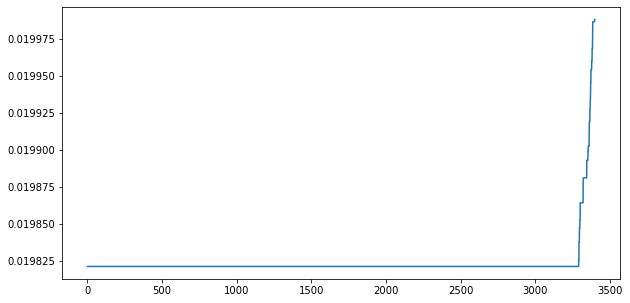

In [252]:

fig, ax = plt.subplots(figsize=(10, 5))
sig_p = fdr_p_3[1][((fdr_p_3[1] < 0.02))]
sig_p = np.sort(sig_p)
plt.plot(np.arange(0,len(sig_p)),sig_p)

array([0.01982119, 0.01982119, 0.01982119, ..., 0.99874837, 0.99894248,
       0.99948261])